In [2610]:
import numpy as np
import pandas as pd
import math

def get_data(filepath):
    x_raw, y_raw = [], []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            line = [float(x) for x in line.strip().split(' ')]
            x_raw += [line[:-1]]
            y_raw += [line[-1]]
        
        return np.array(x_raw), np.array(y_raw)
    
def normalize(x):
    return (x_raw - x_raw.min(axis=0)) / (x_raw.max(axis=0) - x_raw.min(axis=0))
    
def shuffle(x, y):
    
    indice = np.arange(len(x))
    np.random.shuffle(indice)
    return np.array([x[i] for i in indice]),  np.array([y[i] for i in indice])

def split(x, y, split_ratio=2/3):
    
    train_len = math.ceil(len(x) * split_ratio)
    return x[:train_len], y[:train_len], x[train_len:], y[train_len:]

def plot_dataset(x, y):
    
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    x = pd.DataFrame(x)
    classes = np.unique(y)
    
    fig, ax = plt.subplots()
    for i, c in enumerate(classes):
        plt.scatter(x[y == c][0], x[y == c][1], label='Class {}'.format(c), c=colors[i])

    plt.show()

# distance function
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2, ord=2)
    
def time_constant(iteration, constant):
    # iteration: 迭代總次數
    # constant: 常數。這裡可以是有效寬度(sigma)初始值、學習率(leraning_rate)初始值
    return iteration / np.log(constant)

# 計算得勝類神經元 j* 的鄰近區域函數的強度
# 高斯型式之鄰近區域函數
def gaussian(d, sigma, gamma=1):
    # d: 得勝神經元 j* 與 類神經元 j 的側向連結距離
    # sigma: 有效寬度
    return np.exp(- (d**2) / (gamma * sigma**2))
    
# 指數衰減函數
def exponential_decay(init, n, tau):
    # init: 欲衰減參數的初始值。ex: 有效寬度(sigma)初始值、學習率(leraning_rate)初始值
    # n: 第 n 次迭代數
    # tau: 時間常數

    return init * np.exp(-1 * n / tau)

def learning_rate_decay(n, iteration):
    return 0.1 * (1 - n/iteration)

In [2649]:
import matplotlib.pyplot as plt
import sys
%matplotlib inline

class AMSOM:
    def __init__(self, row, col, input_dim, distance_func, kernel_func, sigma_decay_func, lr_decay_func):
        def init_connections(shape='rectangle'):
            def get_neighbors(r, c):
                curr  = (r * row) + c
                right = (r * row) + np.clip(c+1, 0, col-1) # right neighbor id
                down  = (np.clip(r+1, 0, row-1) * row) + c # down  neighbor id
                neighbors = [[], []]
                if curr != right:
                    neighbors[0] += [curr, right]
                    neighbors[1] += [right, curr]
                if curr != down:
                    neighbors[0] += [curr, down]
                    neighbors[1] += [down, curr]
                return neighbors

            if shape == 'rectangle':
                for r in range(row):
                    for c in range(col):
                        self.connections[get_neighbors(r, c)] = 1
            elif shape == 'hexagonal':
                pass
            
        def init_positions(shape='rectangle'):
            if shape == 'rectangle':
                self.positions = np.array([(r, c) for r in range(row) for c in range(col)])
            elif shape == 'hexagonal':
                pass
        
        self.spread_factor = 0.5
        self.gamma = 3
        self.max_age = 30 
        self.epoch_add =  5
        self.epsilon1 = 1e-6
        
        self.row = row
        self.col = col
        self.num = row * col
        self.input_dim = input_dim
        
        self.weights = np.random.uniform(0, 1, (self.num, input_dim))
        self.consciences = np.zeros((self.num))
        self.positions = None 
        self.ages = np.zeros((self.num, self.num))
        self.connections = np.zeros((self.num, self.num))
        self.removed = []
        self.GT = -np.log(input_dim) * np.log(self.spread_factor)  # growing threshold
        
        self.distance_function = distance_func
        self.kernel_function = kernel_func
        self.sigma_decay_function = sigma_decay_func
        self.lr_decay_function = lr_decay_func
        
        init_connections()
        init_positions()
        
        print('GT: {}'.format(self.GT))
        print('weights: {}'.format(self.weights.shape))
        print('ages: {}'.format(self.ages.shape))
        print('connections: {}'.format(self.connections.shape))
        print('position: {}'.format(self.positions.shape))

        self.plot_neuron_map()
        
                                
    def train(self, x_train, y_train, epoch_size, sigma0):
        
        ##### update_consciences #####
        def update_consciences(Na, B=0.001):
            for i in range(self.num):
                self.consciences[i] += B * (int(i==Na) - self.consciences[i])
#             print(self.consciences)
        ##### end of update_consciences #####
        
         ##### get_competition_bias #####
        def get_competition_bias(neuron, C=10):
            return C * (1/self.num - self.consciences[neuron])
        ##### end of get_competition_bias #####
        
        
        
        
        ##### update_edges #####
        def update_edges(Na, Nb):
            # age of all edges between Na and its neighbors increased by one
            to_increase = np.where(self.connections[Na] == 1)[0]
            self.ages[Na, to_increase] += 1
            self.ages[to_increase, Na] += 1
            
            # connect Na with Nb (if they were not already connected)
            self.connections[Na][Nb] = 1
            self.connections[Nb][Na] = 1
            
            # reset age between Na and Nb to zero
            self.ages[Na][Nb] = 0
            self.ages[Nb][Na] = 0
        ##### end of update_edges #####
            
            
#         ##### get_neighbors #####
#         def get_neighbors(Na, sigma):
#             # 回傳類神經元的鄰居(list)
#             sigma = round(sigma)
#             row_lowerbound = self.positions[Na][0] - sigma
#             row_upperbound = self.positions[Na][0] + sigma
#             col_lowerbound = self.positions[Na][1] - sigma
#             col_upperbound = self.positions[Na][1] + sigma
#             neighbors = []
#             for i, pos in enumerate(self.positions):
#                 if (pos[0] >= row_lowerbound and pos[0] <= row_upperbound) and \
#                    (pos[1] >= col_lowerbound and pos[1] <= col_upperbound) and (not i in self.removed):
#                     neighbors.append(i)
#             return np.array(neighbors)
#         ##### end of get_neighbors #####
            
            
        ##### update_weights #####
        def update_weights(feature, win_times, sigma):
            # 更新類神經元的權重
            for i in range(self.num):
                if i in self.removed:
                    continue

                neighbors = np.where(self.connections[i] > 0)[0]
                neighbors = np.append(neighbors, i)
                value1, value2 = 0, 0
                for j in neighbors:
                    distance = self.distance_function(self.positions[i], self.positions[j])
                    value1 += self.kernel_function(distance, sigma) * feature[j]
                    value2 += win_times[j] * self.kernel_function(distance, sigma)
                
                self.weights[i] = (value1 / value2) if value2 != 0 else 0
            
        ##### end of update_weights #####
        
        
        ##### update_positions #####
        def update_positions(win_times, learning_rate):
            # 更新類神經元的位置
            new_positions = np.zeros(self.positions.shape)
            for i in range(self.num):  
                if i in self.removed:
                    continue
                neighbors = np.where(self.connections[i] > 0)[0]
                neighbors = np.append(neighbors, i)
                
                value1, value2 = 0, 0
                for j in neighbors:
                    distance = self.distance_function(self.weights[i], self.weights[j])
                    value1 += win_times[j] * self.kernel_function(distance, sigma, self.gamma) * (self.positions[j] - self.positions[i])
                    value2 += win_times[j] * self.kernel_function(distance, sigma, self.gamma)
                
                new_positions[i] = self.positions[i] + learning_rate * (value1 / value2 if value2 != 0 else 0)
                
            self.positions = new_positions
            
        ##### end of update_positions #####
            
            
        ##### remove_neuron #####
        def remove_neuron():
            old = np.where(self.ages >= self.max_age)
            length = len(old[0])
            for i in range(length):
                self.connections[old[0][i]][old[1][i]] = 0
                self.connections[old[1][i]][old[0][i]] = 0 
                self.ages[old[0][i]][old[1][i]] = 0
                self.ages[old[1][i]][old[0][i]] = 0 
            
            to_removes = np.where(np.sum(self.connections, axis=0) == 0)[0]  # np.where() reutrn tuple (array, )
            
            self.removed = np.unique(np.append(self.removed, to_removes))
        ##### end of remove_neuron #####
        
        
        ##### create_neuron #####
        def create_neuron(x_train):
            def get_max_qe_neuron(neurons):
                neuron, max_qe = -1, -1
                for i in neurons:
                    if i in self.removed:
                        continue
                    qe = self.get_quantization_error(i, x_train)
                    neuron = i if qe > max_qe else neuron
                    max_qe = max(max_qe, qe)
                return neuron, max_qe
            
            Nu, max_qe = get_max_qe_neuron(range(self.num))
            
            if max_qe < self.GT:
                return
            
            neighbors = np.array([i for i in np.where(self.connections[Nu] > 0)[0] if not i in self.removed])
            Nv, _ = get_max_qe_neuron(neighbors)
            
            beta = np.random.normal(0, 1) # mean = 0, variacne = 1
            w1 = (1 + beta) * self.weights[Nu]
            w2 = -beta * self.weights[Nu]
            r1 = self.positions[Nu]
            r2 = (self.positions[Nu] + self.positions[Nv]) / 2
            
            self.num += 1
            self.weights[Nu] = w1
            self.weights = np.append(self.weights, w2[None, :], axis=0)
            self.positions = np.append(self.positions, r2[None, :], axis=0)
            self.connections = np.pad(self.connections, ((0, 1), (0, 1)), 'constant', constant_values=(0))
            self.connections[-1] = self.connections[Nu]
            self.connections[-1][Nu] = 1
            self.connections[-1][Nv] = 1
            
            for i in range(self.num - 1):
                self.connections[i][-1] = self.connections[-1][i]
            
            self.ages = np.pad(self.ages, ((0, 1), (0, 1)), 'constant', constant_values=(0))
        ###### end of create_neuron #####
                
        
        sigma_tau = time_constant(epoch_size, sigma0)
        QE0 = 0
        for epoch in range(1, epoch_size+1):
            sigma = self.sigma_decay_function(sigma0, epoch, sigma_tau)
            learning_rate = self.lr_decay_function(epoch, epoch_size)
            x_train, y_train = shuffle(x_train, y_train)
            
            win_times = np.zeros((self.num))  # the number of patterns that are assigned to neuron
            feature = np.zeros((self.num, self.input_dim))    # feature vector of all x that are assigned to neuron
            
            for x in x_train:
                Na = self.get_winner(x)
                Nb = self.get_winner(x, Na)
                win_times[Na] += 1
                feature[Na] += x
                update_edges(Na, Nb)
#                 update_consciences(Na)
                            

            update_weights(feature, win_times, sigma)
            update_positions(win_times, learning_rate)
            
            remove_neuron()
#             if epoch % self.epoch_add == 0:
#                 create_neuron(x_train)
                
#             if epoch % 10 == 0:
            print('epoch {}'.format(epoch))
            print(self.num - len(self.removed))
            self.plot_neuron_map()
            
#             QE = np.mean([self.get_quantization_error(i, x_train) for i in range(self.num) if not i in self.removed])
#             if abs(QE - QE0) < self.epsilon1:
#                 print(QE - QE0)
#                 print('Epoch: {}, Quantization Error {}'.format(epoch, QE))
#                 break
            
#             QE0 = QE
            
            
    ##### get_winner #####
    def get_winner(self, x, Na=-1):
        # 回傳得勝類神經元的索引值(int)
        winner, min_distance = -1, sys.maxsize
        for i in range(0, self.num):
            if Na == i or i in self.removed:
                continue
            distance = self.distance_function(x, self.weights[i])# - get_competition_bias(i)
            winner = i if distance < min_distance else winner
            min_distance = min(distance, min_distance)
        return winner 
    ##### end of get_winner #####
                    
    def get_quantization_error(self, i, x_train):
        qe = 0
        for x in x_train:
            winner = self.get_winner(x)
            if i == winner:
                qe += self.distance_function(x, winner)
        return qe
            
            
    def plot_neuron_map(self):
        
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']        
        plt.scatter(self.positions[:, 0], self.positions[:, 1], c='b')
        plt.scatter(self.weights[:, 0], self.weights[:, 1], c='r')
        connections = np.where(self.connections == 1)
        node_a = self.positions[connections[0]]
        node_b = self.positions[connections[1]]
        
        
#         curr_max_age = np.max(self.ages)
        for axis_x, axis_y in zip(connections[0], connections[1]):
            a = self.positions[axis_x]
            b = self.positions[axis_y]
            plt.plot([a[0], b[0]], [a[1], b[1]], c='b', lw=1)

        plt.show()
            
            
    
        
        
        

In [2666]:
x_raw, y_raw = get_data('dataset/2CloseS2.txt')
# x_train, y_train = np.random.rand(1000, 2), np.random.rand(1000, 1)
print('size: {}'.format(x_raw.shape))

size: (200, 2)


In [2667]:
x_raw = normalize(x_raw)

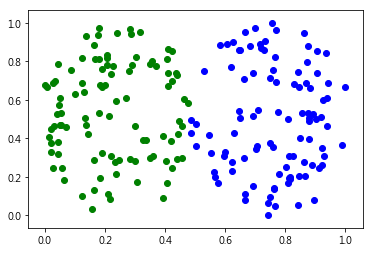

In [2668]:
plot_dataset(x_raw, y_raw)

In [2669]:
x_raw, y_raw = shuffle(x_raw, y_raw)
print(x_raw.shape)

(200, 2)


In [2670]:
x_train, y_train, x_test, y_test = split(x_raw, y_raw)
print(x_train.shape)

(134, 2)


In [2671]:
# parameter

row = 5 # int(5 * int(len(x_train) ** 0.5) ** 0.5)
col = 5 # int(5 * int(len(x_train) ** 0.5) ** 0.5)
input_dim = x_train.shape[1]
epoch_size = row * col * 100
sigma0 = max(row, col) / 2
distance_func = euclidean_distance
kernel_func = gaussian
sigma_decay_func = exponential_decay
lr_decay_func = learning_rate_decay

C:\Users\chiamin\Anaconda3\envs\iisr\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


GT: 0.4804530139182014
weights: (25, 2)
ages: (25, 25)
connections: (25, 25)
position: (25, 2)


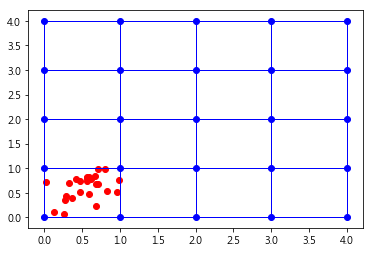

In [2672]:
model = AMSOM(row, col, input_dim, distance_func, kernel_func, sigma_decay_func, lr_decay_func)

In [ ]:
model.train(x_train, y_train, epoch_size, sigma0)